**1. Libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import numpy as np
import os
import glob
import re
import pickle
from datetime import datetime
import urllib.request
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.models import load_model

**2. Data Preparation and Exploration**

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [4]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nValidation Images Shape: ', X_valid.shape)
print('Validation Labels Shape: ', y_valid.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (45000, 32, 32, 3)
Train Labels Shape:       (45000, 1)

Validation Images Shape:  (5000, 32, 32, 3)
Validation Labels Shape:  (5000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


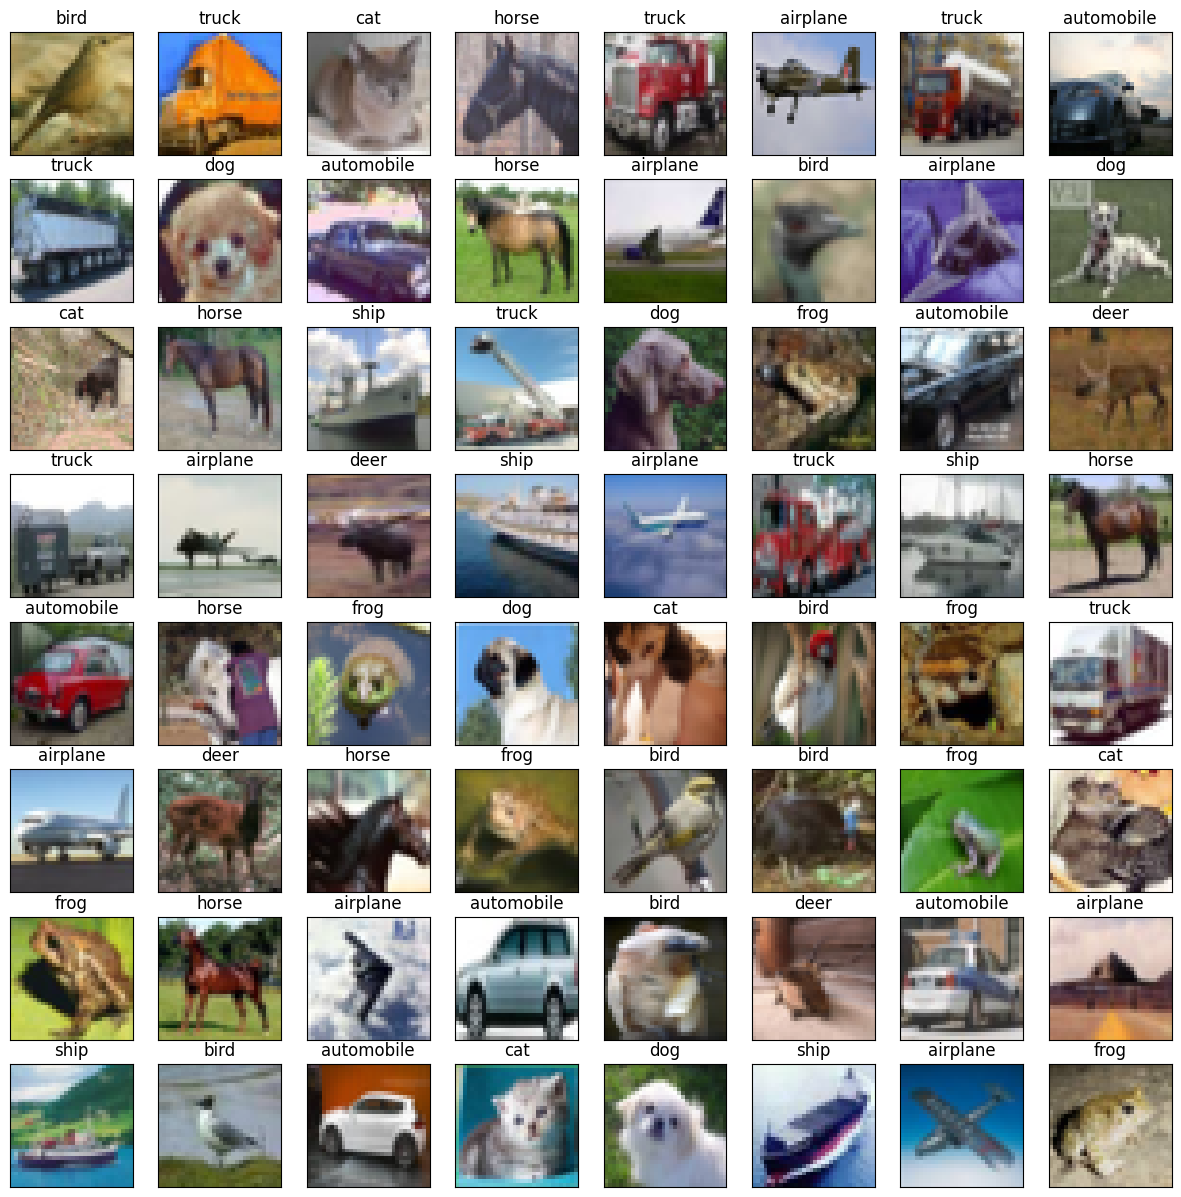

In [5]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
               
# Create a new figure
plt.figure(figsize=(15,15))

# Loop over the first 25 images
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(X_train[i])

    plt.title(class_names[y_train[i][0]], fontsize=12)

plt.show()

**3. Data Preprocessing**

***3.1. Normalization of Image Data***

In [6]:
# Convert pixel values data type to float32
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Calculate the mean and standard deviation of the training images
mean = np.mean(X_train)
std  = np.std(X_train)

# Normalize the data
# The tiny value 1e-7 is added to prevent division by zero
X_train = (X_train-mean)/(std+1e-7)
X_test  = (X_test-mean) /(std+1e-7)
X_valid = (X_valid-mean)/(std+1e-7)

***3.2. One-Hot Encoding of Labels***

In [7]:
y_train = to_categorical(y_train, 10)
y_valid = to_categorical(y_valid, 10)
y_test  = to_categorical(y_test, 10)

***3.3. Data Augmentation***

In [8]:
data_generator = ImageDataGenerator(
    rotation_range=15,      # Rotate images randomly by up to 15 degrees
    
    width_shift_range=0.12,     # Shift images horizontally by up to 12% of their width
    
    height_shift_range=0.12,        # Shift images vertically by up to 12% of their height
    
    horizontal_flip=True,       # Randomly flip images horizontally
    
    zoom_range=0.1,     # Zoom images in by up to 10%
    
    brightness_range=[0.9,1.1],     # Change brightness by up to 10%
    
    shear_range=10,     # Shear intensity (shear angle in counter-clockwise direction in degrees)
    
    channel_shift_range=0.1,        # Channel shift intensity
)

**4. Define CNN Model Architecture**

In [9]:
# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Add the first convolutional layer with 32 filters of size 3x3
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay), 
                 input_shape=X_train.shape[1:]))
model.add(BatchNormalization())     # Add batch normalization layer

# Add the second convolutional layer similar to the first
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))       # Add the first max pooling layer with pool size of 2x2
model.add(Dropout(rate=0.2))        # Add dropout layer with 0.2 dropout rate

# Add the third and fourth convolutional layers with 64 filters
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))   
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))       # Add the second max pooling layer and increase dropout rate to 0.3
model.add(Dropout(rate=0.3))

# Add the fifth and sixth convolutional layers with 128 filters
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))       # Add the third max pooling layer and increase dropout rate to 0.4
model.add(Dropout(rate=0.4))

# Add the seventh and eighth convolutional layers with 256 filters
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay))) 
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))       # Add the fourth max pooling layer and increase dropout rate to 0.5
model.add(Dropout(rate=0.5))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,186,346 (4.53 MB)

 Trainable params: 1,184,426 (4.52 MB)

 Non-trainable params: 1,920 (7.50 KB)

**5. Training the CNN Model**

In [14]:
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("cifar10_final_model", exist_ok=True)

batch_size = 64
epochs = 300

# Safe model compile (already compiled or not)
if not hasattr(model, '_is_compiled') or not model._is_compiled:
    print("Model is not compiled yet -> Compiling now with Adam(0.0005)...")
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    print(f"Model is already compiled -> Keeping current optimizer (lr = {model.optimizer.learning_rate.numpy():.6f})")

# Fixed callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)

checkpoint_best = ModelCheckpoint(
    filepath="checkpoints/best_model.keras",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_every_epoch = ModelCheckpoint(
    filepath="checkpoints/epoch_{epoch:03d}-valacc_{val_accuracy:.4f}.keras",
    save_best_only=False,
    verbose=1
)

# Automatically load the latest checkpoint
initial_epoch = 0
checkpoint_files = glob.glob("checkpoints/epoch_*.keras")

if checkpoint_files:
    latest_file = max(checkpoint_files, key=os.path.getctime)
    match = re.search(r'epoch_(\d+)', latest_file)
    if match:
        initial_epoch = int(match.group(1))
        print(f"CHECKPOINT DETECTED -> CONTINUE FROM EPOCH {initial_epoch}")
        print(f"Loading: {os.path.basename(latest_file)}")
        model = load_model(latest_file)
    else:
        print("Checkpoint found but epoch not clear -> using best_model")
        model = load_model("checkpoints/best_model.keras")
else:
    print("No checkpoint found -> START TRAINING FROM SCRATCH (epoch 0)")

# list of callbacks
callbacks = [reduce_lr, early_stopping, checkpoint_best, checkpoint_every_epoch]

# training
print(f"\nSTART TRAINING FROM EPOCH {initial_epoch} -> {epochs}")
print("-> If disconnected, it will automatically reconnect\n")

history = model.fit(
    data_generator.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    initial_epoch=initial_epoch,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks,
    verbose=2
)

print("\nTRAINING COMPLETED! Saving final model...")

# automatically save final model
save_dir = "cifar10_final_model"

# Save official model
model.save(f"{save_dir}/cifar10_cnn_90plus.keras")
model.save(f"{save_dir}/cifar10_cnn_90plus.h5")
model.export(f"{save_dir}/saved_model_format")

# Save mean/std, class_names, history
with open(f"{save_dir}/norm_stats.pkl", "wb") as f:
    pickle.dump((mean, std), f)
with open(f"{save_dir}/class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)
with open(f"{save_dir}/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Calculate test_acc if not available
try:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
except:
    test_acc = 0.0
    test_loss = 0.0

# Info file
info = {
    "saved_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss),
    "best_val_accuracy": float(max(history.history['val_accuracy'])),
    "total_epochs_trained": len(history.history['loss']),
    "final_epoch": initial_epoch + len(history.history['loss']),
    "note": "Model achieved >90% on CIFAR-10 | Auto resume if interrupted | Keras 3+ ready"
}

with open(f"{save_dir}/INFO.txt", "w", encoding="utf-8") as f:
    for k, v in info.items():
        f.write(f"{k}: {v}\n")

print("\nALL COMPLETED!")
print(f"-> Main model: {save_dir}/cifar10_cnn_90plus.keras")
print(f"-> Deploy: {save_dir}/saved_model_format/")
print(f"-> Temporary checkpoints: checkpoints/")
print(f"-> Final Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")
print(f"-> Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")


Model is not compiled yet -> Compiling now with Adam(0.0005)...
No checkpoint found -> START TRAINING FROM SCRATCH (epoch 0)

START TRAINING FROM EPOCH 0 -> 300
-> If disconnected, it will automatically reconnect

Epoch 1/300

Epoch 1: val_accuracy improved from None to 0.62380, saving model to checkpoints/best_model.keras

Epoch 1: saving model to checkpoints/epoch_001-valacc_0.6238.keras
704/704 - 39s - 56ms/step - accuracy: 0.5650 - loss: 1.4009 - val_accuracy: 0.6238 - val_loss: 1.1991 - learning_rate: 5.0000e-04
Epoch 2/300

Epoch 2: val_accuracy improved from 0.62380 to 0.69340, saving model to checkpoints/best_model.keras

Epoch 2: saving model to checkpoints/epoch_002-valacc_0.6934.keras
704/704 - 39s - 56ms/step - accuracy: 0.6145 - loss: 1.2466 - val_accuracy: 0.6934 - val_loss: 0.9897 - learning_rate: 5.0000e-04
Epoch 3/300

Epoch 3: val_accuracy improved from 0.69340 to 0.69620, saving model to checkpoints/best_model.keras

Epoch 3: saving model to checkpoints/epoch_003-val

INFO:tensorflow:Assets written to: cifar10_final_model/saved_model_format\assets


INFO:tensorflow:Assets written to: cifar10_final_model/saved_model_format\assets


Saved artifact at 'cifar10_final_model/saved_model_format'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  2264387113552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387116816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387114512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387117584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387115088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387115856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387115280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387117200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387119696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387120080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2264387118928

**6. Visualizing the Learning Curves**

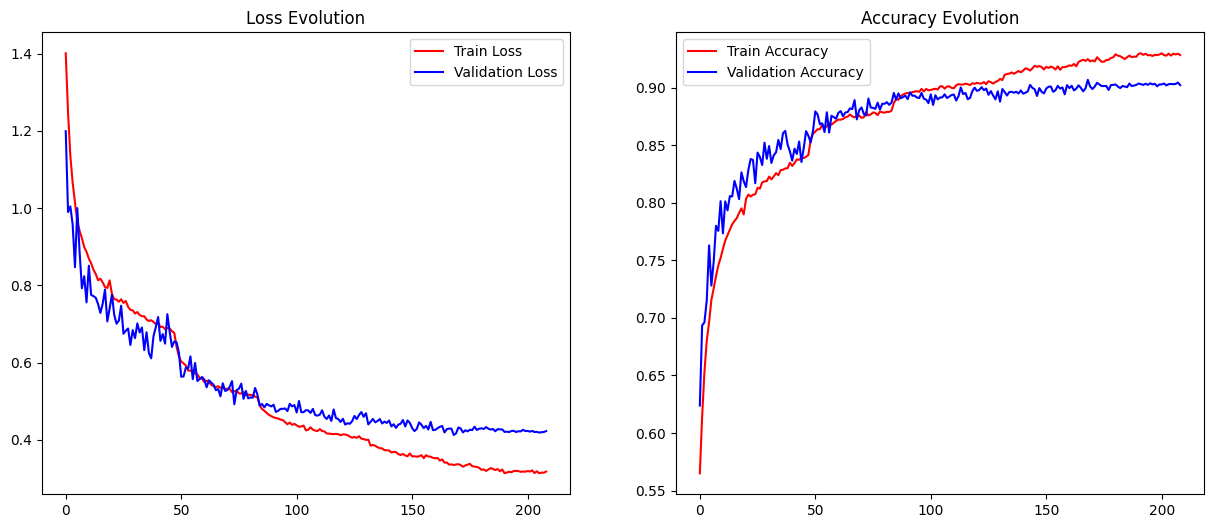

In [15]:
plt.figure(figsize=(15,6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Train Loss', color='red')
plt.plot(model.history.history['val_loss'], label='Validation Loss', color='blue')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy', color='blue')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

**7. Evaluating the Optimal Model on Test Data**

In [16]:
# Use the model to make predictions, evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('Test Loss:    ', test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9048 - loss: 0.4272

Test Accuracy: 0.9047999978065491
Test Loss:     0.42724302411079407


**8. Load model**

In [17]:
# Reload saved model
import tensorflow as tf
import pickle
import os

load_dir = "cifar10_final_model"

print("LOADING MODEL & ALL NECESSARY INFORMATION...\n")

# 1. Load model (prioritize .keras – latest standard)
if os.path.exists(f"{load_dir}/cifar10_cnn_90plus.keras"):
    model = tf.keras.models.load_model(f"{load_dir}/cifar10_cnn_90plus.keras")
    print("Model loaded from .keras file (2025 standard)")
elif os.path.exists(f"{load_dir}/cifar10_cnn_90plus.h5"):
    model = tf.keras.models.load_model(f"{load_dir}/cifar10_cnn_90plus.h5")
    print("Model loaded from file .h5")
else:
    raise FileNotFoundError("Model file not found!!")

# 2. Load mean + std
with open(f"{load_dir}/norm_stats.pkl", "rb") as f:
    mean, std = pickle.load(f)
print("Loaded mean/std to normalize")

# 3. Load class_names
with open(f"{load_dir}/class_names.pkl", "rb") as f:
    class_names = pickle.load(f)
print("class_names loaded")

# 4. Load history (redraw the graph)
with open(f"{load_dir}/training_history.pkl", "rb") as f:
    history = pickle.load(f)
print("training history loaded")

# 5. Print model information
print("\n" + "="*50)
print("MODEL IS READY TO USE!")
print(f"Test Accuracy when saved: {open(f'{load_dir}/INFO.txt').read().split('test_accuracy: ')[1].split()[0]}")
print(f"Number of classes: {len(class_names)} -> {class_names}")
print("="*50)

LOADING MODEL & ALL NECESSARY INFORMATION...

Model loaded from .keras file (2025 standard)
Loaded mean/std to normalize
class_names loaded
training history loaded

MODEL IS READY TO USE!
Test Accuracy when saved: 0.9047999978065491
Number of classes: 10 -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


**9. Prediction image**

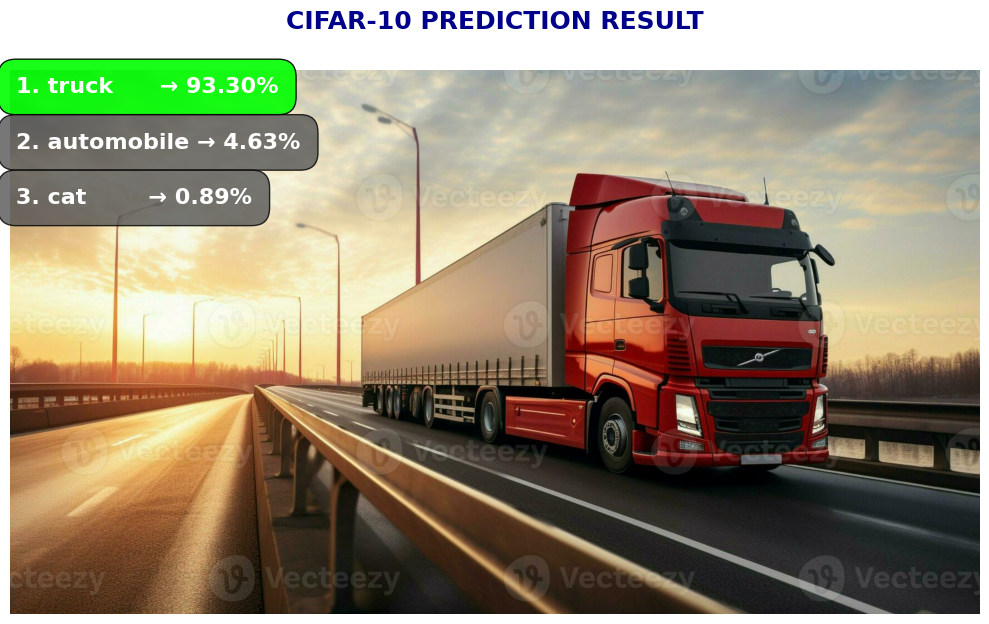

Prediction: truck (93.30%)
   1. truck      → 93.30%
   2. automobile → 4.63%
   3. cat        → 0.89%


('truck', np.float32(0.9330317))

In [34]:
import urllib.request
from PIL import Image
import io

def predict_cifar10(image_input, topk=3):
    # 1. Read image
    if isinstance(image_input, str):
        if image_input.startswith("http"):
            resp = urllib.request.urlopen(image_input)
            img = cv2.imdecode(np.asarray(bytearray(resp.read()), dtype="uint8"), cv2.IMREAD_COLOR)
        else:
            img = cv2.imread(image_input)
            if img is None: raise FileNotFoundError(f"Cannot read image: {image_input}")
    else:
        img = np.array(image_input)
        if img.shape[-1] == 3:
            img = img[:, :, ::-1]  # RGB → BGR

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. Preprocessing
    img_resized = cv2.resize(img_rgb, (32, 32))
    img_norm = (img_resized.astype('float32') - mean) / (std + 1e-7)
    img_input = img_norm.reshape(1, 32, 32, 3)

    # 3. Prediction
    pred = model.predict(img_input, verbose=0)[0]
    top_indices = pred.argsort()[-topk:][::-1]

    # 4. Display
    plt.figure(figsize=(10, 7))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title("CIFAR-10 PREDICTION RESULT", fontsize=18, fontweight='bold', color='darkblue', pad=30)

    x_text = 10
    y_start = 40
    line_height = 100

    for i, idx in enumerate(top_indices):
        text = f"{i+1}. {class_names[idx]:10} → {pred[idx]:.2%}"
        face_color = '#0F0' if i == 0 else '#555'
        plt.text(x_text, y_start + i * line_height, text,
                 fontsize=16, color='white', fontweight='bold',
                 bbox=dict(facecolor=face_color, alpha=0.9 if i==0 else 0.8, 
                           edgecolor='black', boxstyle='round,pad=0.8'))

    plt.tight_layout()
    plt.show()

    # Print to console
    print(f"Prediction: {class_names[top_indices[0]]} ({pred[top_indices[0]]:.2%})")
    for i, idx in enumerate(top_indices):
        print(f"   {i+1}. {class_names[idx]:10} → {pred[idx]:.2%}")

    return class_names[top_indices[0]], pred[top_indices[0]]

# Test
predict_cifar10(r"E:\FALL25\OJT\W5_7\sample\truck_sample.jpg")
